In [1]:
%matplotlib inline

import sys

sys.path.append("..")

In [2]:
import torch
torch.cuda._lazy_init() # avoid "Unknown CUDA error"
torch.cuda.is_available()

True

In [3]:
# Load the Dataset class
from torchvision import transforms

from settings import DATA_SOURCES
from src.datasets.sketchy import Sketchy

# dataset = Sketchy(DATA_SOURCES['sketchy_test']['photos'], transforms.Grayscale(num_output_channels=1))
dataset = Sketchy(DATA_SOURCES['sketchy_test']['photos'])
len(dataset)

1250

In [15]:
# from torchvision.datasets import ImageFolder

# # load with a grayscale transform
# dataset = ImageFolder(
#     root=DATA_SOURCES['sketchy_test']['photos'],
#     transform=transforms.Compose([
#         transforms.Resize(DATA_SOURCES['sketchy']['dimensions'][0]),
#         transforms.CenterCrop(DATA_SOURCES['sketchy']['dimensions'][0]),
#         transforms.Grayscale(num_output_channels=1),
#         transforms.ToTensor(),
# #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])
# )

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torchvision.utils as vutils

# # Plot some training images
# image = dataset[0]
# plt.figure(figsize=(4,4))
# plt.axis("off")
# plt.title("Class: %s" % image[1])
# plt.imshow(np.transpose(vutils.make_grid(image[0].to(device), padding=2, normalize=True).cpu(), (1,2,0)))

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Number of workers for dataloader
workers = 8

# Batch size for dataloader
batch_size = 1

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

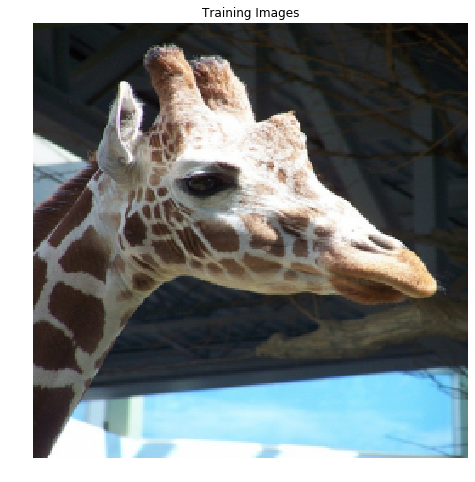

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Create the dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
inputs, labels = next(iter(data_loader))
inputs.shape

torch.Size([1, 3, 256, 256])

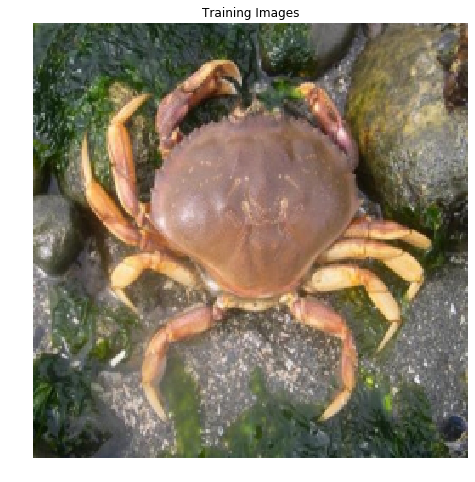

In [7]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(inputs[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

First, a benchmark with OpenCV

In [10]:
# import cv2

# img = inputs[0].numpy()
# sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=1)

In [ ]:
# import matplotlib.pyplot as plt

# plt.imshow(sobelx[0], cmap = 'gray')

In [8]:
from src.models.gradients import SobelX, SobelY

# sobel_x = SobelX(in_channels=1)
# sobel_y = SobelY(in_channels=1)
sobel_x = SobelX()
sobel_y = SobelY()

In [9]:
out = sobel_x(inputs)
out.shape

torch.Size([1, 1, 256, 256])

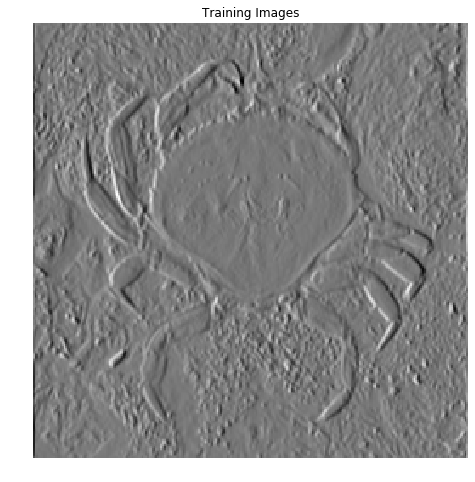

In [10]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(out[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Nice. Now for the HOG.

In [11]:
import torch

gx = sobel_x(inputs)
gy = sobel_y(inputs)

mag = torch.sqrt(gx**2 + gy**2)
ang = torch.atan2(gx, gy)

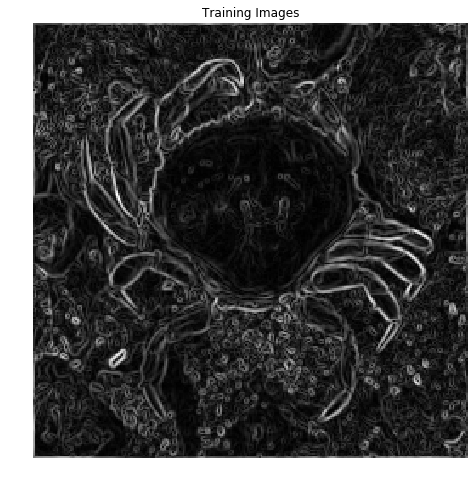

In [12]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(mag[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

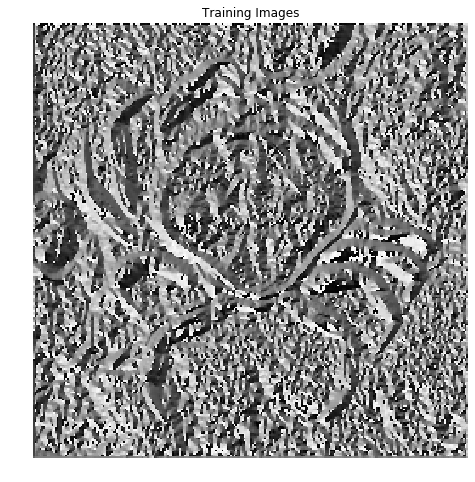

In [13]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(ang[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [14]:
ang.shape

torch.Size([1, 1, 256, 256])

In [15]:
ang

tensor([[[[-2.4904,  2.8492,  2.9380,  ...,  2.6335,  2.3532,  2.3087],
          [-1.7918,  1.9390,  2.6779,  ...,  1.3450,  1.8742,  2.0304],
          [-1.6665,  1.5114, -0.0965,  ...,  1.6053,  1.6571,  1.4458],
          ...,
          [-1.4303, -0.3145, -0.6465,  ...,  1.8634, -1.5836,  1.6329],
          [-1.3696, -0.4332, -0.7601,  ..., -2.9433, -2.1878,  1.8737],
          [-0.7356, -0.1097, -0.1594,  ..., -0.4688, -0.5109,  0.7334]]]])

In [83]:
import math

grad_bins = (ang.abs() / math.pi * 8).floor().long()
grad_bins.shape

torch.Size([1, 1, 256, 256])

In [60]:
torch.nn.functional.one_hot(grad_bins).reshape((1,10,256,256))

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 1, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 1,  ..., 0, 0, 0],
          [0, 1, 0,  ..., 1, 0, 0],
          [0, 0, 1,  ..., 0, 0, 1],
          ...,
          [0, 0, 1,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0]],

         [[1, 0, 0,  ..., 0, 0, 0],
          [1, 0, 0,  ..., 1, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 1, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 1, 0,  ..., 0, 0, 0]],

         ...,

         [[1, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 1,  ..., 0, 0, 1],
          [0, 0, 

In [84]:
a = torch.tensor([[[[1,0],[2,1]]]])
a.shape

torch.Size([1, 1, 2, 2])

In [78]:
aux = torch.zeros((1, 3, 2, 2), dtype=torch.float, device=out.device)
aux.scatter_(1, a, 7)

tensor([[[[0., 7.],
          [0., 0.]],

         [[7., 0.],
          [0., 7.]],

         [[0., 0.],
          [7., 0.]]]])

In [85]:
n, c, h, w = out.shape

aux = torch.zeros((n, 9, h, w), dtype=torch.float, device=out.device)

In [80]:
aux.shape

torch.Size([1, 9, 256, 256])

In [86]:
grad_bins.max()

tensor(8)

In [89]:
scat = aux.scatter_(1, grad_bins, mag)
scat

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4885,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 1.3691, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 7.3067, 7.8565,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 1.0416,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 1.9616, 1.7531,  ..., 0.0000, 0.0000, 0.0000],
          [7.1354, 0.0000, 0.0000,  ..., 3.3848, 5.5657, 6.8252]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [96]:
cell_pooling = torch.nn.AvgPool2d(8, stride=8, padding=0)

hog = cell_pooling(scat) * 8**2
print(hog.shape)
hog

torch.Size([1, 9, 32, 32])


tensor([[[[ 1.7579,  3.9549, 11.7705,  ..., 20.5529, 42.4454,  1.2559],
          [ 1.9515,  1.4835, 13.9118,  ..., 27.2291, 28.3456, 16.5491],
          [ 0.3539,  8.5474, 15.7143,  ..., 11.1615,  0.0000, 28.6021],
          ...,
          [ 0.8593,  2.5988,  1.5041,  ..., 18.0196,  0.2980,  7.6012],
          [ 2.2387,  7.3089,  3.6205,  ...,  5.9259, 96.2208, 19.5307],
          [67.1274, 83.0985, 92.9931,  ..., 69.3024, 55.5294, 31.8053]],

         [[ 0.6553,  9.4442,  2.4136,  ..., 23.7902, 28.2630, 11.8197],
          [12.2270,  2.8716, 21.2676,  ..., 30.8290,  5.0602, 10.7243],
          [ 4.1400,  8.8565, 14.6303,  ..., 13.3177, 12.6920, 14.7368],
          ...,
          [ 1.7431,  5.8225,  3.1080,  ..., 12.2489,  0.8066,  9.9976],
          [20.9592,  8.2053, 10.0498,  ...,  8.9915, 16.3129, 72.6674],
          [22.1785,  9.7633,  5.8578,  ...,  4.7044, 10.9072, 24.5457]],

         [[ 2.6437,  8.1468, 19.0373,  ..., 11.6468,  9.5976, 10.2834],
          [16.7655, 20.0435, 1

In [98]:
hog.flatten()

tensor([ 1.7579,  3.9549, 11.7705,  ...,  0.0000,  0.0000,  2.5255])

In [100]:
hog.flatten().shape

torch.Size([9216])

In [ ]:
from src.models.hog import HOG

net = HOG()

In [8]:
net(inputs)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

In [ ]:
for i, data in enumerate(data_loader, 0): # iterate batches
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    print(inputs)
#     outputs = net(inputs)